In [1]:
import os
import json
import glob
import random
import collections

import numpy as np
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers



TYPES = ["FLAIR", "T1w", "T2w", "T1wCE"]
WHITE_THRESHOLD = 10 # out of 255
EXCLUDE = [109, 123, 709]
train_df = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")
test_df = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv')
train_df = train_df[~train_df.BraTS21ID.isin(EXCLUDE)]

In [2]:
train_df.head()

BraTS21ID  MGMT_value
0          0           1
1          2           1
2          3           0
3          5           1
4          6           1

<AxesSubplot:xlabel='MGMT_value', ylabel='count'>

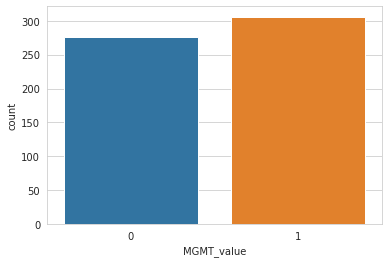

In [3]:
import seaborn as sns

sns.set_style('whitegrid')
sns.countplot(x='MGMT_value', data=train_df)

# Data Loading

In [4]:
def load_dicom(path, size = 224, scale = .8):
    ''' 
    Reads a DICOM image, standardizes so that the pixel values are between 0 and 1, then rescales to 0 and 255
    
    Note super sure if this kind of scaling is appropriate, but everyone seems to do it. 
    '''
#     dicom = pydicom.read_file(path)
#     data = dicom.pixel_array
#     if np.max(data) != 0:
#         data = data / np.max(data)
#     data = (data * 255).astype(np.uint8)
#     return cv2.resize(data, (size, size))
#     Load single image
    img = pydicom.read_file(path).pixel_array
    # Crop image
    center_x, center_y = img.shape[1] / 2, img.shape[0] / 2
    width_scaled, height_scaled = img.shape[1] * scale, img.shape[0] * scale
    left_x, right_x = center_x - width_scaled / 2, center_x + width_scaled / 2
    top_y, bottom_y = center_y - height_scaled / 2, center_y + height_scaled / 2
    img = img[int(top_y):int(bottom_y), int(left_x):int(right_x)]
    # Resize image
    img = cv2.resize(img, (size, size))
    return img

def get_all_image_paths(brats21id, image_type, folder='train'): 
    '''
    Returns an arry of all the images of a particular type for a particular patient ID
    '''
    assert(image_type in TYPES)
    
    patient_path = os.path.join(
        "../input/rsna-miccai-brain-tumor-radiogenomic-classification/%s/" % folder, 
        str(brats21id).zfill(5),
    )

    paths = sorted(
        glob.glob(os.path.join(patient_path, image_type, "*")), 
        key=lambda x: int(x[:-4].split("-")[-1]),
    )
    
    num_images = len(paths)
    
    start = int(num_images * 0.25)
    end = int(num_images * 0.75)

    interval = 3
    
    if num_images < 10: 
        interval = 1
    
    return np.array(paths[start:end:interval])

def get_all_images(brats21id, image_type, folder='train', size=225):
    return [load_dicom(path, size) for path in get_all_image_paths(brats21id, image_type, folder)]
IMAGE_SIZE = 224

def get_all_data_for_train(image_type):
    global train_df
    
    X = []
    y = []
    train_ids = []

    for i in tqdm(train_df.index):
        x = train_df.loc[i]
        images = get_all_images(int(x['BraTS21ID']), image_type, 'train', IMAGE_SIZE)
        label = x['MGMT_value']

        X += images
        y += [label] * len(images)
        train_ids += [int(x['BraTS21ID'])] * len(images)
        assert(len(X) == len(y))
    return np.array(X), np.array(y), np.array(train_ids)

def get_all_data_for_test(image_type):
    global test_df
    
    X = []
    test_ids = []

    for i in tqdm(test_df.index):
        x = test_df.loc[i]
        images = get_all_images(int(x['BraTS21ID']), image_type, 'test', IMAGE_SIZE)
        X += images
        test_ids += [int(x['BraTS21ID'])] * len(images)

    return np.array(X), np.array(test_ids)

In [5]:
data_directory = "../input/rsna-miccai-brain-tumor-radiogenomic-classification/"

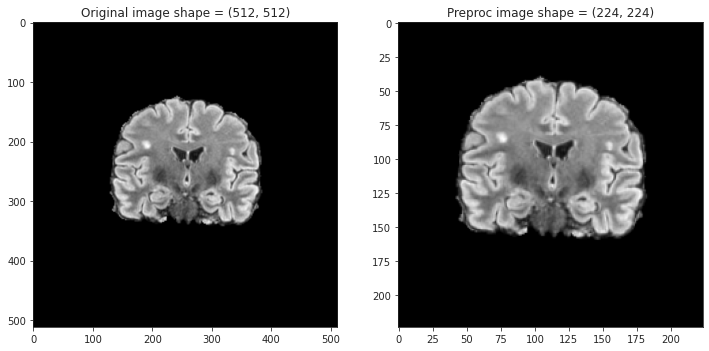

In [6]:
sns.set_style('ticks')
sample_img = pydicom.read_file(
    data_directory+"train/00046/FLAIR/Image-90.dcm").pixel_array
preproc_img = load_dicom(data_directory+"train/00046/FLAIR/Image-90.dcm")


fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot(1,2,1)
ax1.imshow(sample_img, cmap="gray")
ax1.set_title(f"Original image shape = {sample_img.shape}")
ax2 = plt.subplot(1,2,2)
ax2.imshow(preproc_img, cmap="gray")
ax2.set_title(f"Preproc image shape = {preproc_img.shape}")
plt.show()
fig.savefig("pre-proc.png")

# Data Loading

In [7]:
X, y, trainidt = get_all_data_for_train("FLAIR")

  0%|          | 0/582 [00:00<?, ?it/s]

In [8]:
label_count = np.bincount(y)
print("Total No. of Dataset", len(y))
print("No. of Malignant images", label_count[1])
print("No. of benevolent images", label_count[0])

Total No. of Dataset 12463
No. of Malignant images 7297
No. of benevolent images 5166


In [9]:
X_train, X_valid, y_train, y_valid, trainidt_train, trainidt_valid = train_test_split(X, y, trainidt, test_size=0.2, random_state=40)

X_train = tf.expand_dims(X_train, axis=-1)
X_valid = tf.expand_dims(X_valid, axis=-1)

y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, trainidt_train.shape, trainidt_valid.shape

2022-02-25 22:24:41.868171: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 22:24:41.956345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 22:24:41.957124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 22:24:41.963843: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

(TensorShape([9970, 224, 224, 1]),
 (9970, 2),
 TensorShape([2493, 224, 224, 1]),
 (2493, 2),
 (9970,),
 (2493,))

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True)

# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator()

In [11]:
train = image_gen.flow(
      X_train,
      y_train,
      batch_size=32
      )

valid = test_data_gen.flow(
      X_valid,
      y_valid, 
      batch_size=32
      )

In [12]:
for X_batch, Y_batch in train:
    print(X_batch.shape, " ", Y_batch.shape)
    break

(32, 224, 224, 1)   (32, 2)


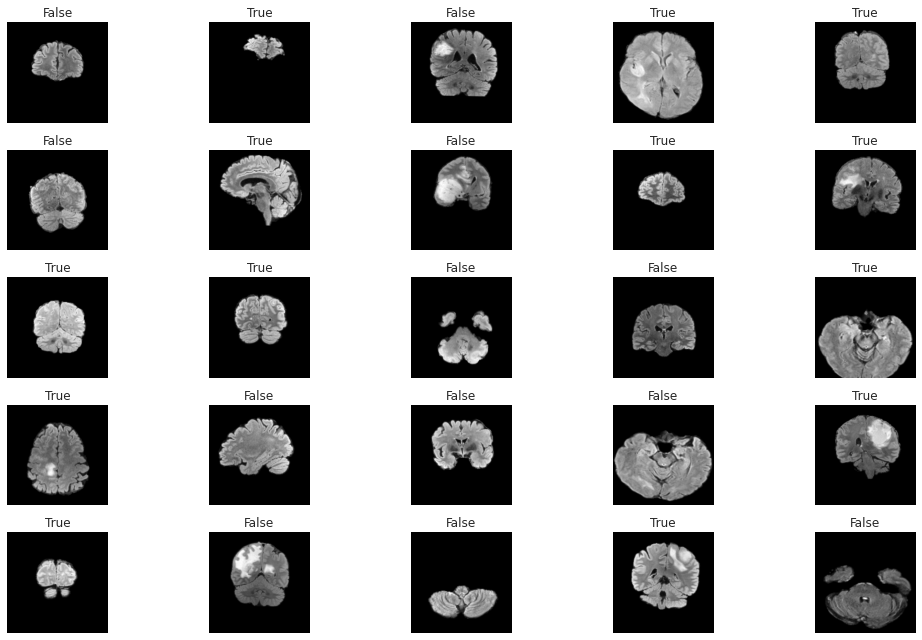

In [13]:
sns.set_style('ticks')
def visualize(imgs, targets):
    fig, ax = plt.subplots(5, 5, figsize=(15, 9))
    for i in range(5):
        for j in range(5):
            n = np.random.randint(0, len(X))
            img = X[n]
            label = y[n] == 1
            ax[i,j].imshow(img, cmap="gray")
            ax[i,j].axis('off')
            ax[i,j].set_title(label)
    plt.tight_layout()

visualize(X, y)

# Model Building

In [14]:
from tensorflow.keras.applications import EfficientNetB0

num_classes = 2

inputs = layers.Input(shape=(224, 224, 3))
#x = img_augmentation(inputs)
model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

# Freeze the pretrained weights
model.trainable = True

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

# Compile
model = tf.keras.Model(inputs, outputs, name="EfficientNet")
optimizer = tf.keras.optimizers.Adam(learning_rate =0.0001)
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=[tf.keras.metrics.AUC(), "accuracy"]
)

16719872/16705208 [==============================] - 0s 0us/step


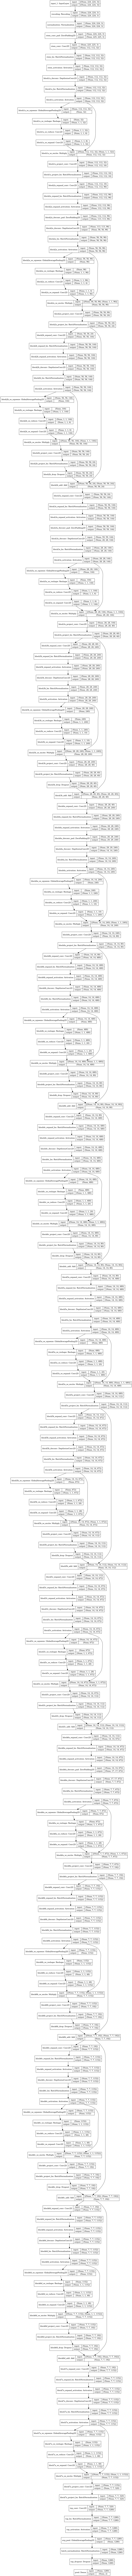

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [16]:
checkpoint_filepath = 'best_model.h5'
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience = 3, verbose=1,factor=0.3, min_lr=0.000001)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                            filepath=checkpoint_filepath,
                            save_weights_only=False,
                            monitor='val_accuracy',
                            mode='max',
                            save_best_only=True,
                            save_freq='epoch')

callbacks_list = [early, learning_rate_reduction, model_checkpoint_callback]

# Model Training

In [17]:
history = model.fit(train, epochs=50, callbacks=[model_checkpoint_callback], validation_data=valid, batch_size=32)

2022-02-25 22:24:56.773014: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-02-25 22:25:05.669851: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


312/312 [==============================] - 90s 242ms/step - loss: 0.8791 - auc: 0.5900 - accuracy: 0.5592 - val_loss: 0.7626 - val_auc: 0.5547 - val_accuracy: 0.5351


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
312/312 [==============================] - 73s 234ms/step - loss: 0.7194 - auc: 0.6830 - accuracy: 0.6339 - val_loss: 0.6932 - val_auc: 0.7099 - val_accuracy: 0.6482
Epoch 3/50
312/312 [==============================] - 73s 232ms/step - loss: 0.6618 - auc: 0.7260 - accuracy: 0.6646 - val_loss: 0.6675 - val_auc: 0.7104 - val_accuracy: 0.6438
Epoch 4/50
312/312 [==============================] - 73s 233ms/step - loss: 0.5968 - auc: 0.7714 - accuracy: 0.6936 - val_loss: 0.5645 - val_auc: 0.8007 - val_accuracy: 0.7184
Epoch 5/50
312/312 [==============================] - 74s 236ms/step - loss: 0.5383 - auc: 0.8137 - accuracy: 0.7314 - val_loss: 0.5240 - val_auc: 0.8263 - val_accuracy: 0.7441
Epoch 6/50
312/312 [==============================] - 74s 237ms/step - loss: 0.4933 - auc: 0.8447 - accuracy: 0.7584 - val_loss: 0.5304 - val_auc: 0.8191 - val_accuracy: 0.7240
Epoch 7/50
312/312 [==============================] - 72s 231ms/step - loss: 0.4346 - auc: 0.8793 - accuracy: 0.789

In [18]:
import pandas as pd

pd.DataFrame(history.history).to_csv("history_efbo.csv")

In [19]:
history = pd.DataFrame(history.history)

In [20]:
history.head()

loss       auc  accuracy  val_loss   val_auc  val_accuracy
0  0.879081  0.589970  0.559178  0.762608  0.554702      0.535098
1  0.719396  0.683020  0.633902  0.693225  0.709899      0.648215
2  0.661829  0.725953  0.664594  0.667483  0.710387      0.643803
3  0.596777  0.771435  0.693581  0.564508  0.800726      0.718412
4  0.538287  0.813721  0.731394  0.523993  0.826265      0.744083

In [21]:
history.rename(columns = {"loss": "Loss", "accuracy": "Accuracy", "val_loss": "Val loss", "val_accuracy": "Val accuracy"}, inplace=True)

In [22]:
plt.rcParams["font.family"] = "Times New Roman"

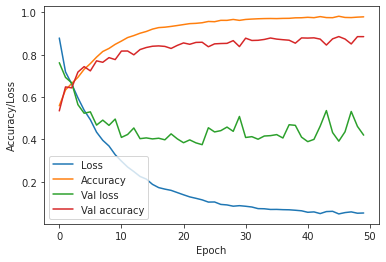

In [23]:
history[["Loss", "Accuracy", "Val loss", "Val accuracy"]].plot(xlabel="Epoch", ylabel="Accuracy/Loss")
plt.savefig("b0_plot.png")

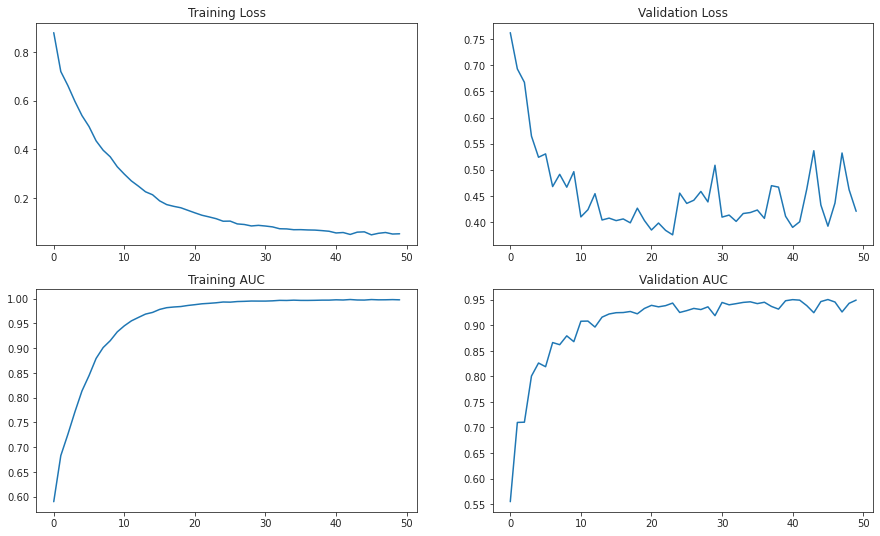

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(15, 9))
ax[0,0].title.set_text("Training Loss")
ax[0,0].plot(history['Loss'])
ax[0,1].title.set_text("Validation Loss")
ax[0,1].plot(history['Val loss'])
ax[1,0].title.set_text("Training AUC")
ax[1,0].plot(history['auc'])
ax[1,1].title.set_text("Validation AUC")
ax[1,1].plot(history['val_auc'])
plt.savefig("b0_learning_curve.png")

# Evaluation

In [25]:
file_path = './best_model.h5'

model_best = tf.keras.models.load_model(filepath=file_path)

In [26]:
y_pred = model.predict(X_valid)

pred = np.argmax(y_pred, axis=1)

# Confusion Matrix

In [27]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

print("Accuracy Score: {:.3f}".format(accuracy_score(np.argmax(y_valid, axis=1), pred)))
print(classification_report(np.argmax(y_valid, axis=1), pred, target_names=['0', '1']))

Accuracy Score: 0.886
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1052
           1       0.90      0.91      0.90      1441

    accuracy                           0.89      2493
   macro avg       0.88      0.88      0.88      2493
weighted avg       0.89      0.89      0.89      2493



In [28]:
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(np.argmax(y_valid, axis=1), pred)

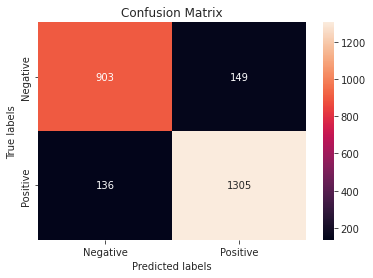

In [29]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.savefig("b0_confusion_matrix.png")

# AUC Curve

In [30]:
from sklearn.metrics import roc_curve,roc_auc_score

fpr, tpr, thresholds = roc_curve(np.argmax(y_valid, axis=1), pred)

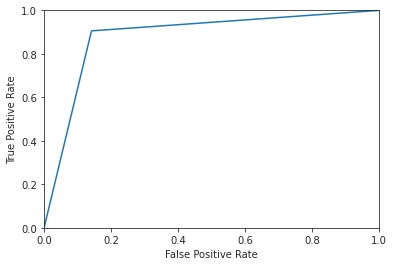

In [31]:
plt.plot(fpr,tpr) 
plt.axis([0,1,0,1]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.show()